In [50]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense,Dropout

In [51]:
PATH_TO_DATA = '/Users/saifuddinshaikh/Downloads/LP-IV-datasets/ECGdataset(Ass4)/ecg_autoencoder_dataset.csv'

In [52]:
data = pd.read_csv(PATH_TO_DATA,header=None)

In [70]:
data.head(5)

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1


In [54]:
data.shape

(4998, 141)

In [69]:
data[140].unique()

array([1, 0])

In [55]:
features = data.drop(140,axis=1)

In [56]:
target = data[140]

In [57]:
X_train, X_test, y_train, y_test = train_test_split(features,target,test_size=0.2,stratify=target)

In [58]:
train_index = y_train[y_train==1].index
train_data = X_train.loc[train_index]

In [59]:
minmaxscaler = MinMaxScaler(feature_range=(0,1))
x_train_scaled = minmaxscaler.fit_transform(train_data.copy())
x_test_scaled = minmaxscaler.transform(X_test.copy())

In [60]:
class AutoEncoder(Model):
    def __init__(self,output_units,ldim=8):
        super().__init__()
        self.encoder = Sequential([
            Dense(64,activation='relu'),
            Dropout(0.1),
            Dense(32,activation='relu'),
            Dropout(0.1),
            Dense(16,activation='relu'),
            Dropout(0.1),
            Dense(ldim,activation='relu')
        ])
        self.decoder = Sequential([
            Dense(16,activation='relu'),
            Dropout(0.1),
            Dense(32,activation='relu'),
            Dropout(0.1),
            Dense(64,activation='relu'),
            Dropout(0.1),
            Dense(output_units,activation='sigmoid')
        ])
    def call(self,inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

In [61]:
model = AutoEncoder(output_units=x_train_scaled.shape[1])
model.compile(loss='msle', metrics=['mse'], optimizer='adam')
history = model.fit(
 x_train_scaled,
 x_train_scaled,
 epochs=20,
 batch_size=512,
 validation_data=(x_test_scaled, x_test_scaled)
)

Epoch 1/20
5/5 [==============================] - 1s 29ms/step - loss: 0.0115 - mse: 0.0258 - val_loss: 0.0136 - val_mse: 0.0316
Epoch 2/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0113 - mse: 0.0252 - val_loss: 0.0133 - val_mse: 0.0311
Epoch 3/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0108 - mse: 0.0241 - val_loss: 0.0130 - val_mse: 0.0302
Epoch 4/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0099 - mse: 0.0222 - val_loss: 0.0127 - val_mse: 0.0295
Epoch 5/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0089 - mse: 0.0200 - val_loss: 0.0125 - val_mse: 0.0291
Epoch 6/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0079 - mse: 0.0177 - val_loss: 0.0119 - val_mse: 0.0276
Epoch 7/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0070 - mse: 0.0157 - val_loss: 0.0113 - val_mse: 0.0264
Epoch 8/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0063 - mse: 0.0140 - val_loss: 

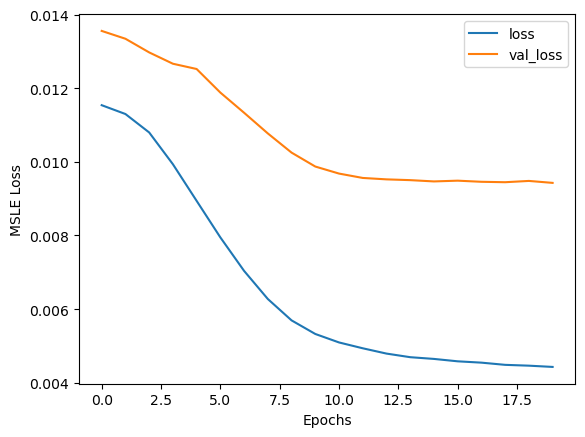

In [62]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [63]:
#finding threshold for anomaly and doing predictions
def find_threshold(model, x_train_scaled):
 reconstructions = model.predict(x_train_scaled)
 reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
 threshold = np.mean(reconstruction_errors.numpy()) + np.std(reconstruction_errors.numpy())
 return threshold
def get_predictions(model, x_test_scaled, threshold):
 predictions = model.predict(x_test_scaled)
 errors = tf.keras.losses.msle(predictions, x_test_scaled)
 anomaly_mask = pd.Series(errors) > threshold
 preds = anomaly_mask.map(lambda x: 0.0 if x == True else 1.0)
 return preds
threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")

73/73 [==============================] - 0s 550us/step
Threshold: 0.009568602900591121


In [64]:
#getting accuracy score
predictions = get_predictions(model, x_test_scaled, threshold)
accuracy_score(predictions, y_test)

32/32 [==============================] - 0s 596us/step


0.95